In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
import util
array = util.read_data()
array

array([[ 0.,  2., 97., ...,  5.,  1., 43.],
       [ 0.,  2., 96., ...,  5.,  1., 45.],
       [ 0.,  2., 95., ...,  5.,  0., 46.],
       ...,
       [ 0., 10., 93., ...,  2.,  1., 40.],
       [ 0., 10., 93., ...,  3.,  1., 41.],
       [ 0., 11., 91., ...,  1.,  0., 42.]])

According to Taken's Theorem we would need $2 * d + 1$ dimensions (the first and the subsequent $2 * d$ timesteps) in order to get a valid embedding of the original data, where $d$  is the intrinsic dimension of the data. Due to the fact that we are actually measuring the amount of persons per timestep and also because it is periodical we can assume that the result will be a one-dimensional, closed loop. Hence, $d = 1$ and we will create a 3-dimensional embedding.

Task 5 - Subtask 1

In [3]:
# Remove the unnecessary columns
needed_columns = array[:, :3]
#Because we need 351 datapoints for a frame, we will have 351 less datapoints in the end (the last 351 will not have enough remaining data points in order for them to remain included)
M = needed_columns.shape[0] - 351
windows = np.zeros((M, 1053))

# Creating the different intervals
for index in range(M):
    window = needed_columns[index:350+index+1]
    windows[index] = np.ndarray.flatten(window)

#Performing the PCA Decomposition with 3 components accordingly to Taken's theorem
pca = PCA(n_components=3)

windows_reduced = pca.fit_transform(windows)

Task 5 - Subtask 2

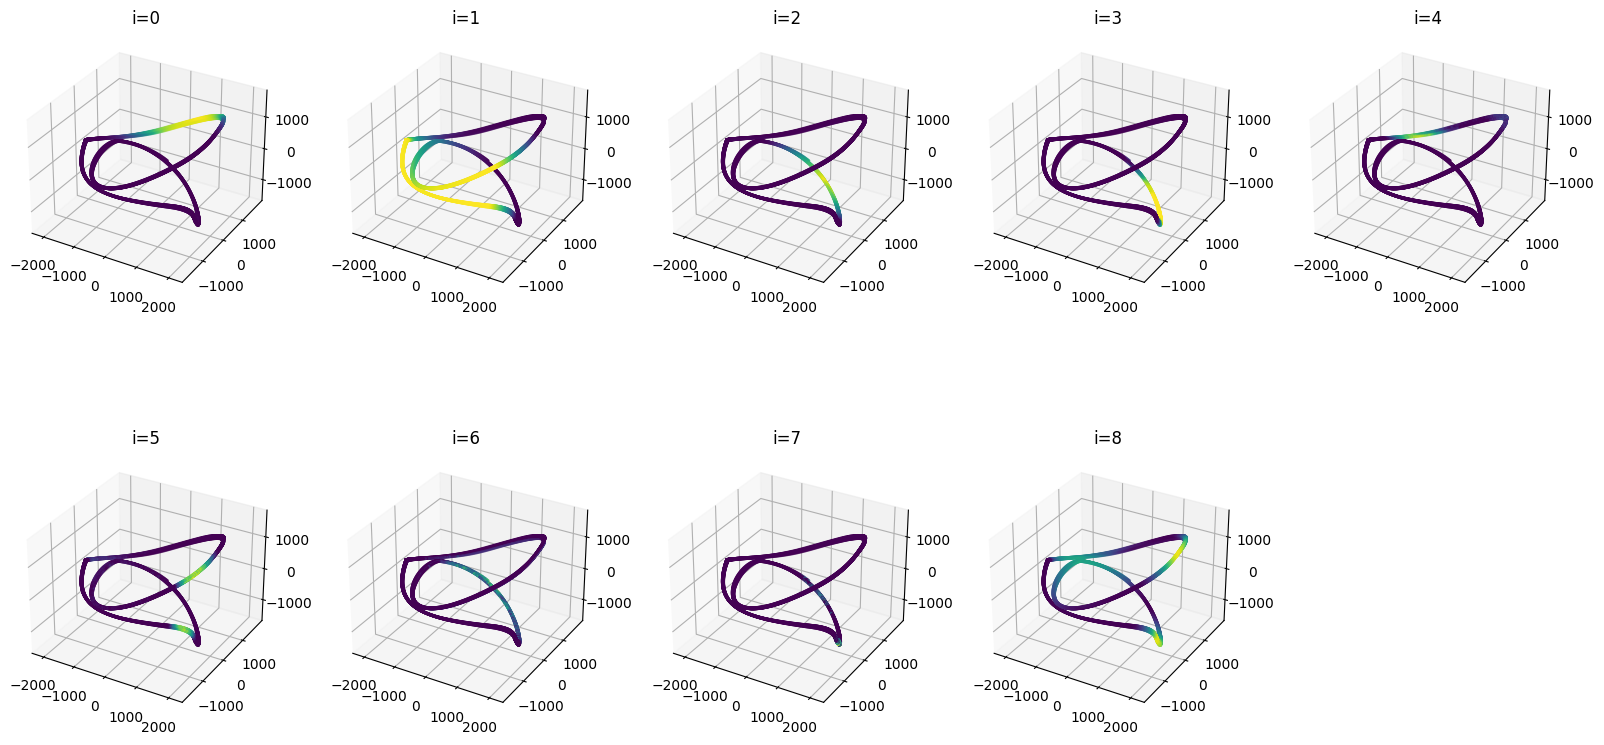

In [26]:
# We plot the points and color them accordingly to their respective measurement area
fig = plt.figure(figsize=(20,10))
for i in range(9):
    ax = fig.add_subplot(2,5,i+1, projection='3d')
    ax.scatter(*windows_reduced.T,s=1,c=array[:M,i])
    ax.set_title("i={index}".format(index=i))

plt.show()

Task 5 - Subtask 3

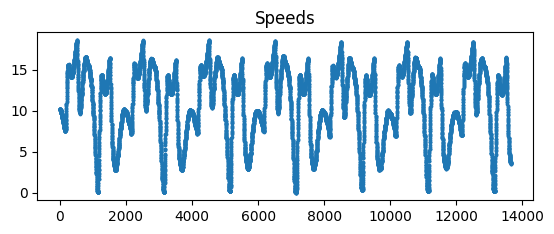

In [5]:
# Calculating the vector fields (we called them speeds) of the data points in the 3D subspace
speeds = np.zeros(windows_reduced.shape[0] - 1)

# We store the arclength-s for each 2 consecutive points in the speeds vector. Since it is a basic implementations we only have to calculate the difference between 2 consecutive data points (and divide them by 1, as this is the constant timestep.
for i in range(windows_reduced.shape[0]-1):
    speeds[i] = np.linalg.norm(windows_reduced[i+1] - windows_reduced[i])

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(range(speeds.shape[0]), speeds, s = 3)
ax1.set_title("Speeds")



plt.show()

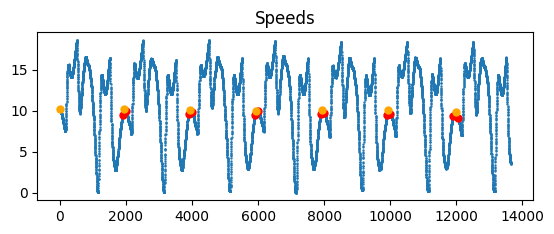

In [6]:
# Finding the period
# In order to store the periods we perform the following manual procedure:
# We assume that every period starts with the value that the whole data set starts. We also observe that this value is represented by the peak of a small concave region.
# We amnually select all the points that represent the maximum of these concave regions by choosing 2 points on the sides and taking the maxmum of the resulting interval.
# After this we calculate the different periods and we store their average in the variable period = 1999.
# In i_start_s we store the x value representing the start of a new period.
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(range(speeds.shape[0]), speeds, s = .5)
ax1.set_title("Speeds")

_, periods, i_start_s = util.check_periods(ax1, speeds)

period = int(np.average(periods))

plt.show()

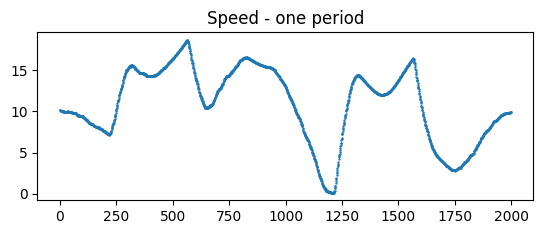

In [7]:
# We present a single period of the speed (the third period)
speed_period = speeds[i_start_s[2]:i_start_s[2] + period]
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(range(period), speed_period, s = .5)
ax1.set_title("Speed - one period")
plt.show()

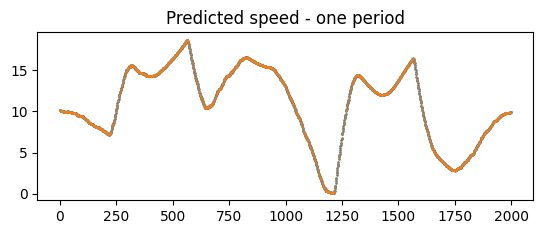

In [8]:
# We set L equal to the period value, basically we are overfitting a new curve to the speed vector.
# That is why the value of epsilon does not play a big role in this case.
epsilon = 1
L = period

# These are the x coordinates
xs = np.array([*range(period)])
# C is calculated with the help of the functions we described in util.py
C = np.asarray(util.find_C(xs,epsilon,L,speed_period))

fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(xs, util.phi_X(xs, epsilon, L) @ C, s = .7)
ax1.scatter(range(period), speed_period, s = .1)

ax1.set_title("Predicted speed - one period")
plt.show()

Task 5 - Subtask 4

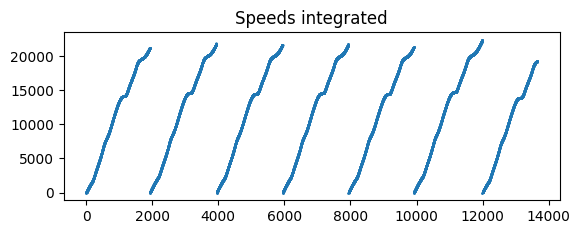

In [9]:
# Firstly, we create a vector that represents the integrated speed along the timesteps. In order to do this we will have to reset the speed every time we reach the end of a period. That is why we previously calculate the i_start_s variable.

speed_integrated = np.zeros(speeds.shape[0])
current_i_start = 0
for i in range(speeds.shape[0]):
    if current_i_start < len(i_start_s) and i == i_start_s[current_i_start]:
        #print(i)
        current_i_start += 1
        speed_integrated[i] = 0
        continue
    speed_integrated[i] = speed_integrated[i-1] + speeds[i]

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(range(speed_integrated.shape[0]), speed_integrated, s = .5)
ax1.set_title("Speeds integrated")

plt.show()

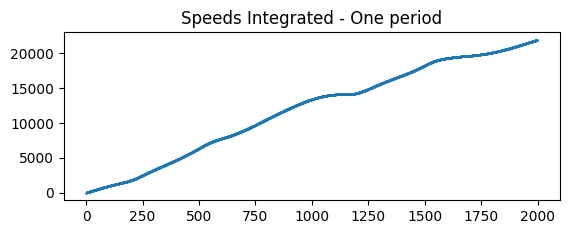

In [10]:
# For the representation back in the original "MI" space we will only need one period, which we are creating here.

speed_integrated_period = np.zeros(period)
for i in range(1, period):
    speed_integrated_period[i] = speed_integrated_period[i-1] + speeds[i]

fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter([*range(period)], speed_integrated_period, s = .5)
ax1.set_title("Speeds Integrated - One period")
plt.show()

Task 5 - Subtask 4

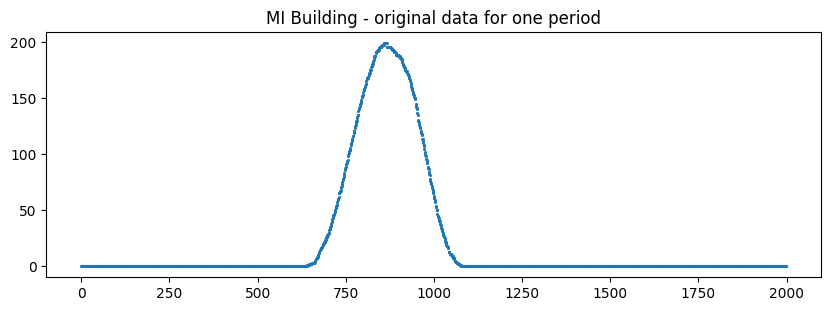

In [11]:
# The utilization of the MI building
# We start by plotting the original data for the MI Building

# This is the data from MI during the third period
MI_period = needed_columns[i_start_s[2]:i_start_s[2] + period,0]
# This is the data from MI during all the periods
MI_full = needed_columns[:,0]

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax1.scatter(range(MI_period.shape[0]), MI_period, s = 1.5)
ax1.set_title("MI Building - original data for one period")
plt.show()

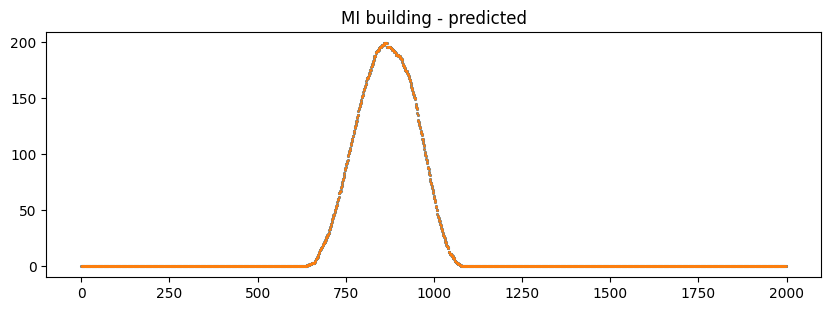

In [27]:
# We learn the representation from the previously calculated integrated speed to the "MI" data by non-linear approximations. We used the same argumentation as before for epsilon and L.

new_epsilon = 1
new_L = period

xs = np.array([*range(speed_integrated_period.shape[0])])

C = np.asarray(util.find_C(speed_integrated_period,new_epsilon,new_L,MI_period))
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)

ax1.scatter(range(MI_period.shape[0]), MI_period, s = 1.5)
ax1.scatter(xs, util.phi_X(speed_integrated_period, new_epsilon, new_L) @ C, s = .5)
ax1.set_title("MI building - predicted")
plt.show()


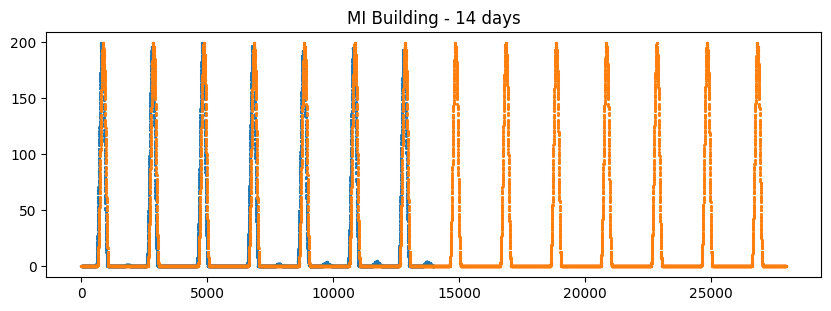

In [13]:
# This is the approximated data from MI during one period
MI_one_prediction = util.phi_X(speed_integrated_period, new_epsilon, new_L) @ C
# Because of the periodical nature of the data, in order to present the first 7 and following 7 days, we will only repeat the calculated period 14 times.
predicted_full = np.tile(MI_one_prediction, 14)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax1.scatter(range(MI_full.shape[0]), MI_full, s = 1.5)
ax1.scatter(range(predicted_full.shape[0]), predicted_full, s = 1.5)
ax1.set_title("MI Building - 14 days")

plt.show()